<a href="https://colab.research.google.com/github/aashu-0/learn-pytorch/blob/main/08_pretrained_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup Data

In [1]:
try:
  from torchinfo import summary
  from torchmetrics import Accuracy
except:
  print('[INFO] Installing torchinfo and torchmetrics')
  !pip install -q torchinfo
  !pip install torchmetrics

[INFO] Installing torchinfo and torchmetrics
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 11.6 MB/s eta 0:00:00


In [2]:
try:
  from modualr_pytorch import data_setup, engine, get_data
except:
  print('[INFO] Downloading scripts from github...')
  !git clone https://github.com/aashu-0/learn-pytorch
  !mv learn-pytorch/modualr_pytorch .
  !rm -rf learn-pytorch
  from modualr_pytorch import data_setup, engine, get_data

[INFO] Downloading scripts from github...
Cloning into 'learn-pytorch'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 90 (delta 33), reused 5 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 48.21 MiB | 16.53 MiB/s, done.
Resolving deltas: 100% (33/33), done.
data/pizza_steak_sushi does not exists...creating one
Downloading....the github zip file
Unzipping the zip file


In [3]:
# loading data using get_data.py script

train_dir = get_data.image_path/'train'
test_dir = get_data.image_path/'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Using a Pretrained ViT model from `torchvision.models`

Why pretrained? cost and time

`TPU v4 pod` renting price/month $2350 = around 2 lakh INR :O and
time =30 days

In [4]:
import torch
import torchvision
from torch import nn

torch.__version__, torchvision.__version__

('2.5.1+cu121', '0.20.1+cu121')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Setting up pretrained model

ViT Base with patch size 16: `torchvision.models.vit_b_16`

In [6]:
# get pretrained weights
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# model instance
pretrained_vit = torchvision.models.vit_b_16(weights= pretrained_vit_weights).to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 56.2MB/s]


In [7]:
# get automatic transforms
pretrained_vit_transforms = pretrained_vit_weights.transforms()
pretrained_vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

#### create train and test dataloaders

In [8]:
import os

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform= pretrained_vit_transforms,
    batch_size= 32,
    num_workers =os.cpu_count()
)

In [9]:
# freeze the base parameters
for parm in pretrained_vit.parameters():
  parm.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# modify the classifier head
pretrained_vit.heads = nn.Linear(in_features = 768,
                                 out_features = len(class_names)).to(device)

pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [10]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=[32,3,224,224],
        col_names= ['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

Let's train...

In [11]:
from modualr_pytorch import engine

#optimizer
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

#accuracy
from torchmetrics import Accuracy
acc_fn= Accuracy(task= 'multiclass', num_classes=len(class_names)).to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit_results = engine.train(model= pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader = test_dataloader_pretrained,
                                      optimizer= optimizer,
                                      loss_fn = loss_fn,
                                      accuracy_fn= acc_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.7663 | Train acc: 0.7188 | Test Loss: 0.5435 | Test acc: 0.8769
Epoch: 1 | Train Loss: 0.3436 | Train acc: 0.9453 | Test Loss: 0.3257 | Test acc: 0.8977
Epoch: 2 | Train Loss: 0.2068 | Train acc: 0.9492 | Test Loss: 0.2698 | Test acc: 0.9186
Epoch: 3 | Train Loss: 0.1557 | Train acc: 0.9609 | Test Loss: 0.2414 | Test acc: 0.9186
Epoch: 4 | Train Loss: 0.1244 | Train acc: 0.9727 | Test Loss: 0.2271 | Test acc: 0.8977
Epoch: 5 | Train Loss: 0.1210 | Train acc: 0.9766 | Test Loss: 0.2122 | Test acc: 0.9280
Epoch: 6 | Train Loss: 0.0933 | Train acc: 0.9766 | Test Loss: 0.2342 | Test acc: 0.8883
Epoch: 7 | Train Loss: 0.0793 | Train acc: 0.9844 | Test Loss: 0.2268 | Test acc: 0.9081
Epoch: 8 | Train Loss: 0.1084 | Train acc: 0.9883 | Test Loss: 0.2064 | Test acc: 0.9384
Epoch: 9 | Train Loss: 0.0646 | Train acc: 0.9922 | Test Loss: 0.1795 | Test acc: 0.9176


Plot loss curves

In [12]:
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
def plot_loss_curve(results: Dict[str, List[float]]):
  # loss values
  train_loss = results['train_loss']
  test_loss = results['test_loss']

  # accuracy values
  # move tensors to the CPU before converting to numpy
  train_accuracy = [tensor.cpu() for tensor in results['train_acc']]
  test_accuracy = [tensor.cpu() for tensor in results['test_acc']]

  # epochs as list
  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15,7))

  # plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label ='train_loss')
  plt.plot(epochs, test_loss, label ='test_loss')
  plt.xlabel("Epochs")
  plt.ylabel('Loss')
  plt.title('Loss Curves')
  plt.legend()

  # plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, train_accuracy, label ='train_accuracy')
  plt.plot(epochs, test_accuracy, label ='test_accuracy')
  plt.xlabel("Epochs")
  plt.ylabel('Accuracy')
  plt.title('Accuracy Curves')
  plt.legend()

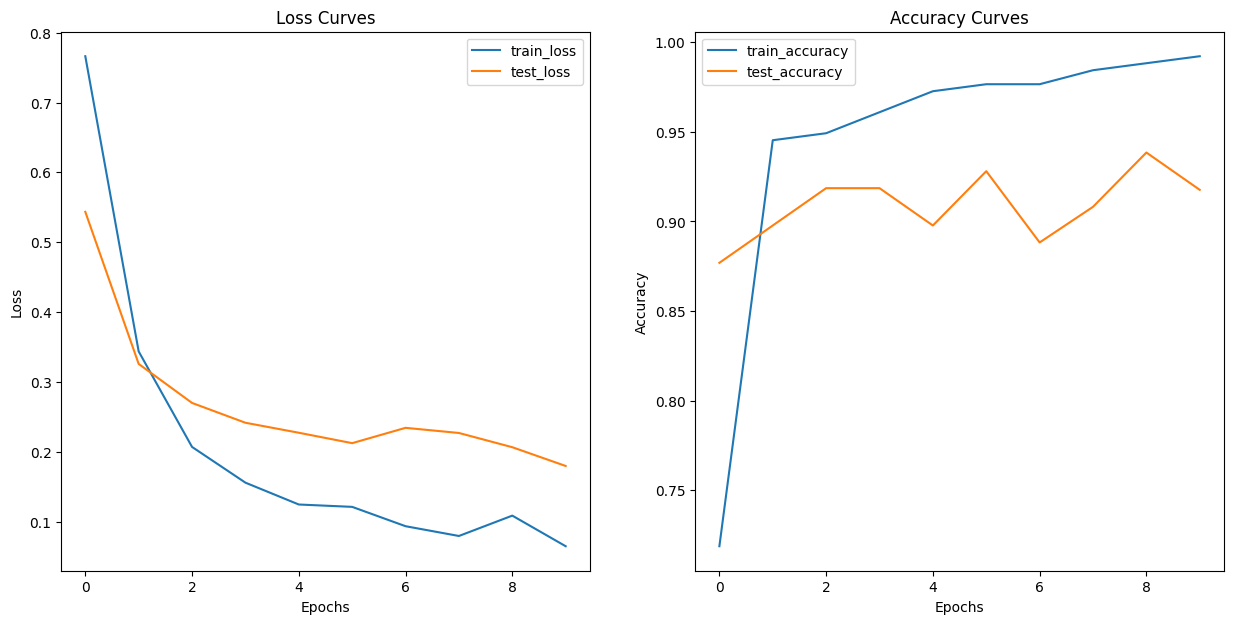

In [13]:
plot_loss_curve(pretrained_vit_results)

Save feature extractor ViT model

In [14]:
from modualr_pytorch import utils

utils.save_model(model= pretrained_vit,
                 target_dir = 'models',
                 model_name= '08_pretrained_ViT_feature_extractor.pth')

Saving model to: models/08_pretrained_ViT_feature_extractor.pth


In [15]:
# checl size

from pathlib import Path
pretrained_vit_model_size = Path('models/08_pretrained_ViT_feature_extractor.pth').stat().st_size //(1024*1024)

print(f'Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB')

Pretrained ViT feature extractor model size: 327 MB


### Prediction on custom Image

In [16]:
# download custom image
import requests
from pathlib import Path

#setup path
data_path = Path('data/')
custom_image_path = data_path/'pizza-image.jpeg'

# download if not already exist
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get("https://raw.githubusercontent.com/aashu-0/images/refs/heads/main/IMG_20230924_214608.jpg")
    print(f'Downloading {custom_image_path}...')
    f.write(request.content)
else:
  print(f'{custom_image_path} already exists')

In [17]:

# custom prediction function to make prediction giving input as image file path

from PIL import Image
from typing import Tuple, List
from torchvision import transforms

def pred_plot_img(model: torch.nn.Module,
                  image_path: str,
                  class_names: List[str],
                  image_size: Tuple[int,int] =(224,224),
                  transform: torchvision.transforms =None,
                  device: torch.device = device):
  # load the image
  img = Image.open(image_path)

  # transform
  if transform is not None:
    img_transform = transform

  else:
    img_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean= [0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ])

  # to device
  model.to(device)

  # evaluation mode
  model.eval()
  with torch.inference_mode():
    # transform and add extra dim
    transformed_img = img_transform(img).unsqueeze(dim=0)

    # make preds
    target_img_pred = model(transformed_img.to(device))

  # logits -> probab
  target_img_pred_probs = torch.softmax(target_img_pred, dim=1)

  # probab -> preds labels
  target_img_pred_label = torch.argmax(target_img_pred_probs, dim=1)

  # plot the image and preds prob
  plt.figure()
  plt.imshow(img)
  title = f"Pred: {class_names[target_img_pred_label]} | Prob: {target_img_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

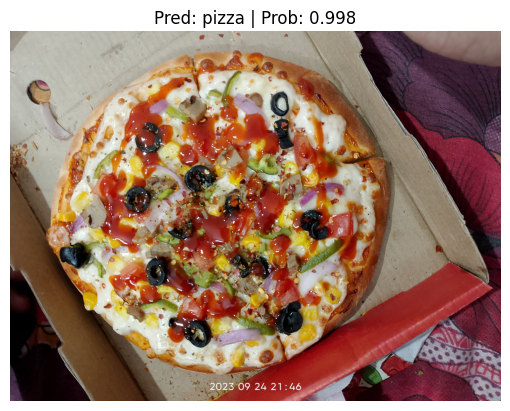

In [18]:
# make pred
pred_plot_img(model=pretrained_vit,
              image_path=custom_image_path,
              class_names=class_names)

f... 99% accuracy ⚡🔥